# Estimation of station access/egress time distribution.

1 - Selection of trips arriving in DEF, associated with only $1$ feasible run.

**Estimations**:

4 - Quick estimation of mean and coefficient of variation for walking distance from observed egress time.

5 - Estimation of parameters with bi bariate gaussian distribution assumption.

6 - Estimation with assumption of log normal distribution.

In [3]:
from matplotlib import pyplot
from math import sqrt
from numpy import log, mean, std
from pandas import Timestamp, read_csv, to_datetime
from scipy.stats import norm
from scipy import optimize

from data import Data

In [1]:
DB_PATH = "/home/justine/Cired/Data/AFC_AVL_2020_02/RERA_202002.db"

### Read data.

### Read and prepare AVL data.

In [6]:
AVL_arrival_all = read_csv(PATHS + "AVL201503/AVL_arrivee_20150316.csv", encoding="latin-1", skiprows=[0, 1])
AVL_departure_all = read_csv(PATHS + "AVL201503/AVL_arrivee_20150316.csv", encoding="latin-1", skiprows=[0, 1])


### All trains and trip arrivals in La Defense.
In both directions... **filter trips in one direction ?**

In [7]:
AVL_arrival_vincennes = AVL_arrival_all[(~AVL_arrival_all["VIN"].isna())].loc[:, ["VIN"]]

AVL_arrival_vincennes["VIN"] = "16/03/2015 " + AVL_arrival_vincennes["VIN"] 
AVL_arrival_vincennes = AVL_arrival_vincennes.applymap(to_datetime, errors="coerce", format="%d/%m/%Y %H:%M:%S")
AVL_arrival_vincennes = AVL_arrival_vincennes.dropna()

AVL_arrival_vincennes = AVL_arrival_vincennes.sort_values(by="VIN")

In [8]:
AFC_vincennes = AFC_all[AFC_all["LIBL_D"] == "VINCENNES"]

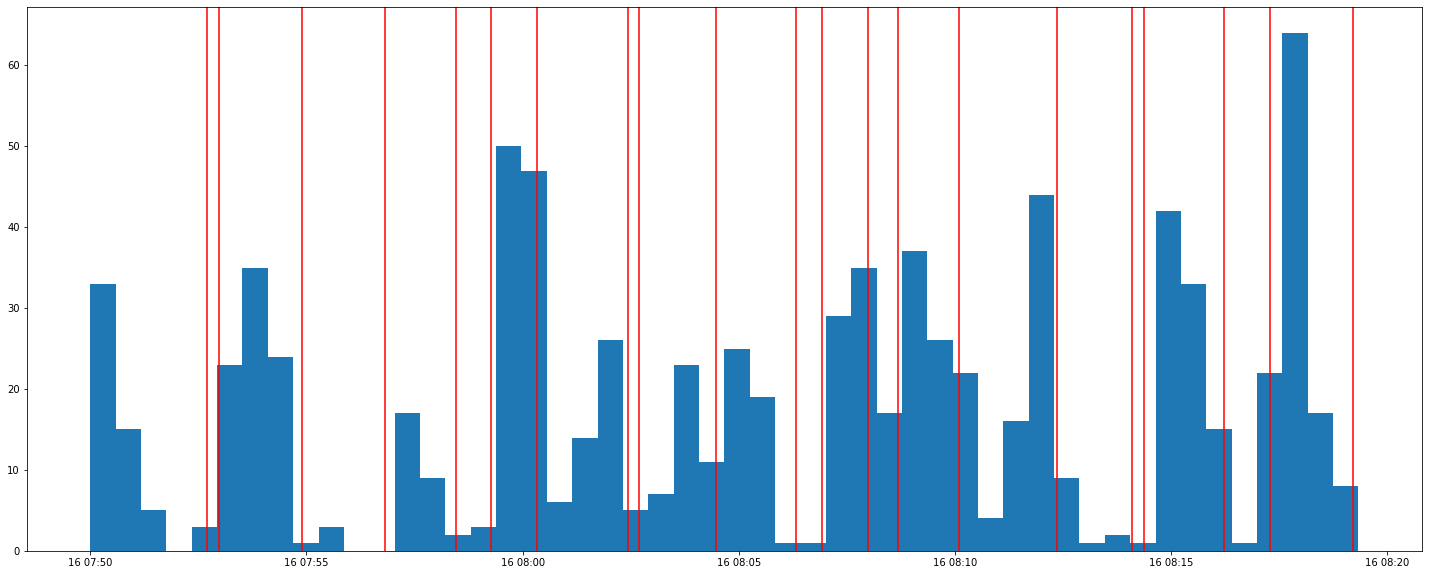

In [9]:
t_inf = Timestamp("16-03-2015 07:50")
t_sup = Timestamp("16-03-2015 08:20")

AVL_arrival_vincennes_time_window = AVL_arrival_vincennes[(AVL_arrival_vincennes["VIN"] >= t_inf) & (AVL_arrival_vincennes["VIN"] <= t_sup)]
AFC_vincennes_time_window = AFC_vincennes[(AFC_vincennes["H_D"] >= t_inf) & (AFC_vincennes["H_D"] <= t_sup)]

pyplot.rcParams["figure.figsize"] = [25, 10]

pyplot.hist(AFC_vincennes_time_window["H_D"], bins=50)
for x in AVL_arrival_vincennes_time_window["VIN"]:
    pyplot.axvline(x, color='red')


## Between La Défense and Vincennes.

In [10]:
direction = 1

AVL_arrival_vincennes_from_la_defense = AVL_arrival_all[(~AVL_arrival_all["DEF"].isna()) & (~AVL_arrival_all["VIN"].isna()) & (AVL_arrival_all["Voie"] == direction)].loc[:, ["VIN"]]

AVL_arrival_vincennes_from_la_defense["VIN"] = "16/03/2015 " + AVL_arrival_vincennes_from_la_defense["VIN"] 
AVL_arrival_vincennes_from_la_defense = AVL_arrival_vincennes_from_la_defense.applymap(to_datetime, errors="coerce", format="%d/%m/%Y %H:%M:%S")
AVL_arrival_vincennes_from_la_defense = AVL_arrival_vincennes_from_la_defense.dropna()

AVL_arrival_vincennes_from_la_defense = AVL_arrival_vincennes_from_la_defense.sort_values(by="VIN")


In [11]:
AFC_vincennes_defense = AFC_all[(AFC_all["LIBL_D"] == "VINCENNES") & (AFC_all["LIBL_O"] == "LA_DEFENSE_GRANDE_ARCHE")]

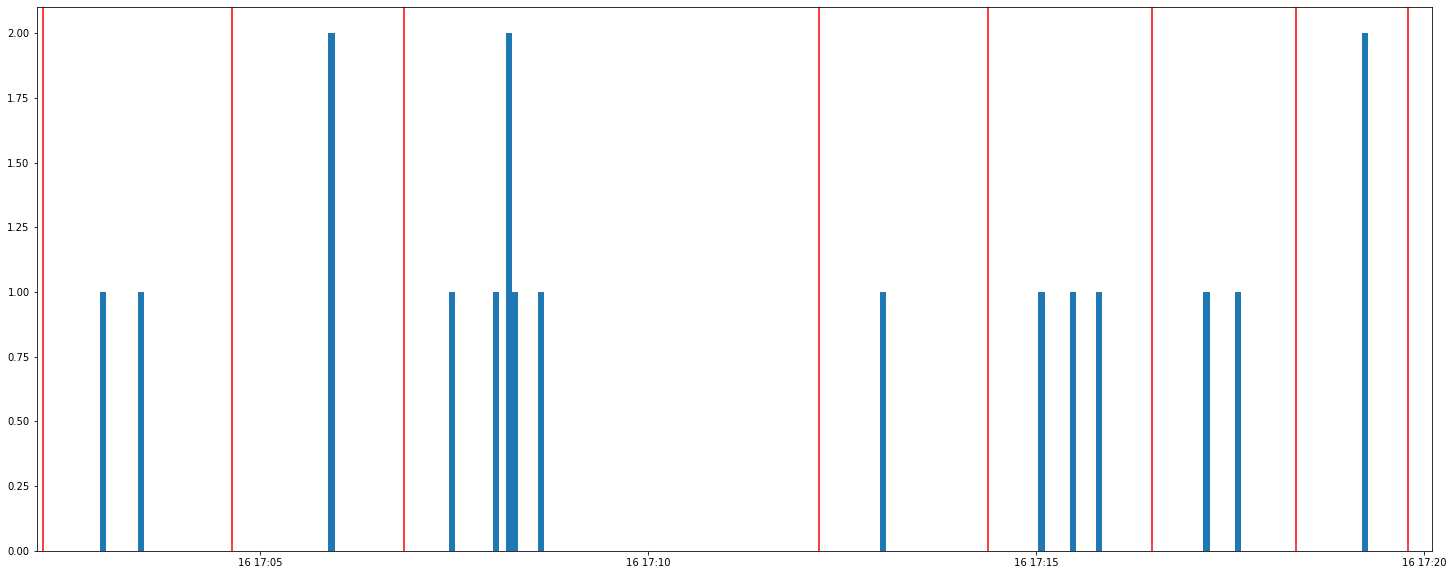

In [12]:
t_inf = Timestamp("16-03-2015 17:00")
t_sup = Timestamp("16-03-2015 17:20")

AVL_arrival_vin_def_time_window = AVL_arrival_vincennes_from_la_defense[(AVL_arrival_vincennes_from_la_defense["VIN"] >= t_inf) & (AVL_arrival_vincennes_from_la_defense["VIN"] <= t_sup)]
AFC_vin_def_time_window = AFC_vincennes_defense[(AFC_vincennes_defense["H_D"] >= t_inf) & (AFC_vincennes_defense["H_D"] <= t_sup)]

pyplot.rcParams["figure.figsize"] = [25, 10]

pyplot.hist(AFC_vin_def_time_window["H_D"], bins=200)
for x in AVL_arrival_vin_def_time_window["VIN"]:
    pyplot.axvline(x, color='red')

### Crossing with feasible runs.

In [13]:
PATHS = "data/AVL-AFC-2015/"
station_destination = "VINCENNES"
station_origin = "LA_DEFENSE_GRANDE_ARCHE"
date = "2015-03-16"
direction = "east"

data = Data(PATHS, date, direction, station_origin, station_destination)

data.compute_feasible_runs()

Computing feasible runs...


100%|██████████| 1186/1186 [00:01<00:00, 914.97it/s]


In [14]:
feasible_runs = []
for trip_id in AFC_vincennes_defense.index:
    try: 
        feasible_runs.append(data.feasible_runs_dict["last_feasible_run", trip_id] - data.feasible_runs_dict["first_feasible_run", trip_id] + 1)
    except KeyError:
        feasible_runs.append(0)

AFC_vincennes_defense["Feasible_run"] = feasible_runs

/tmp/ipykernel_34717/2692104753.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AFC_vincennes_defense["Feasible_run"] = feasible_runs


In [15]:
t_inf = Timestamp("16-03-2015 7:30")
t_sup = Timestamp("16-03-2015 8:30")

AVL_arrival_vin_def_time_window = AVL_arrival_vincennes_from_la_defense[(AVL_arrival_vincennes_from_la_defense["VIN"] >= t_inf) & (AVL_arrival_vincennes_from_la_defense["VIN"] <= t_sup)]
AFC_vin_def_time_window = AFC_vincennes_defense[(AFC_vincennes_defense["H_D"] >= t_inf) & (AFC_vincennes_defense["H_D"] <= t_sup)]


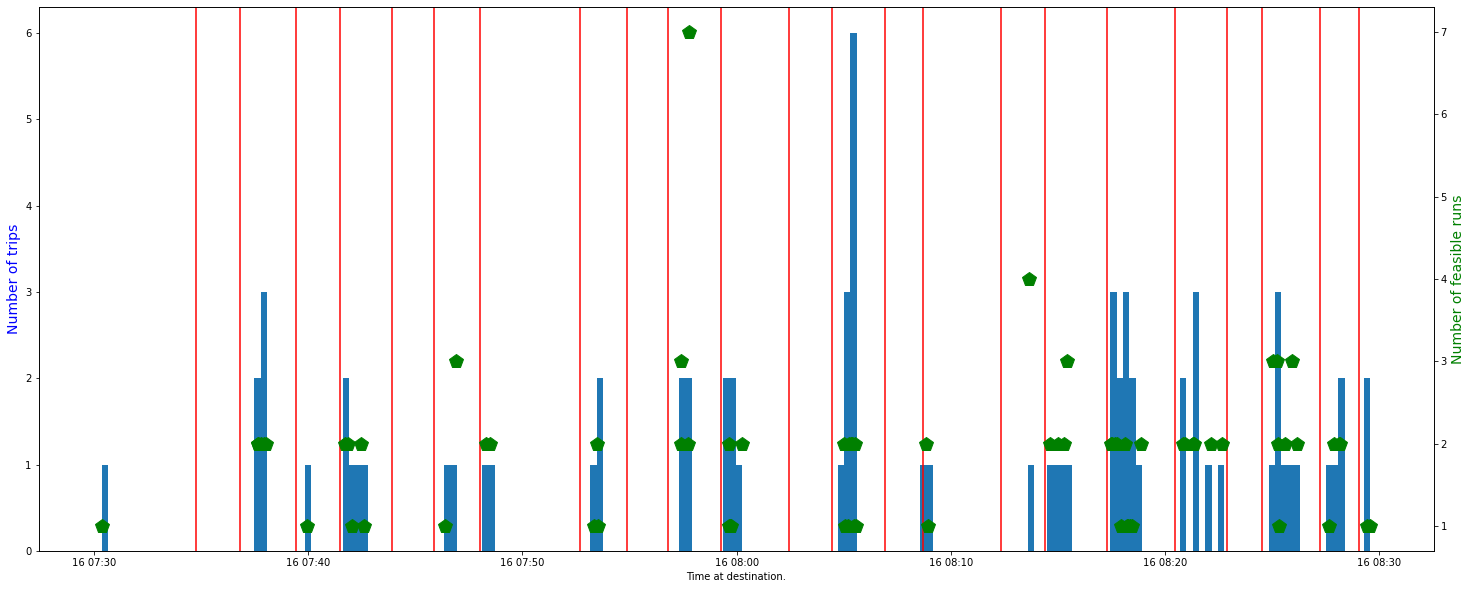

In [16]:
pyplot.rcParams["figure.figsize"] = [25, 10]
fig,ax = pyplot.subplots()
ax.set_xlabel("Time at destination.")
ax2=ax.twinx()

ax.hist(AFC_vin_def_time_window["H_D"], bins=200)
ax.set_ylabel("Number of trips",fontsize=14, color = "blue")

ax2.plot(AFC_vin_def_time_window["H_D"], AFC_vin_def_time_window["Feasible_run"],'p', markersize=14, color = "green")
ax2.set_ylabel("Number of feasible runs",fontsize=14, color="green")

for x in AVL_arrival_vin_def_time_window["VIN"]:
    ax.axvline(x, color='red')

### Walking distance in La Defense from Vincennes when $n_{\text{feasible runs}} = 1$.

In [17]:
AVL_arrival_vincennes_from_la_defense = AVL_arrival_vincennes_from_la_defense.reset_index(drop=True)

walking_time_egress = []
for trip_id in AFC_vincennes_defense.index:
    if AFC_vincennes_defense.loc[trip_id,"Feasible_run"] == 1:
        feasible_run = data.feasible_runs_dict["last_feasible_run", trip_id]
        walking_time_egress.append((AFC_vincennes_defense.loc[trip_id,"H_D"] - AVL_arrival_vincennes_from_la_defense.loc[feasible_run,"VIN"]).total_seconds())


Text(0, 0.5, 'Distribution.')

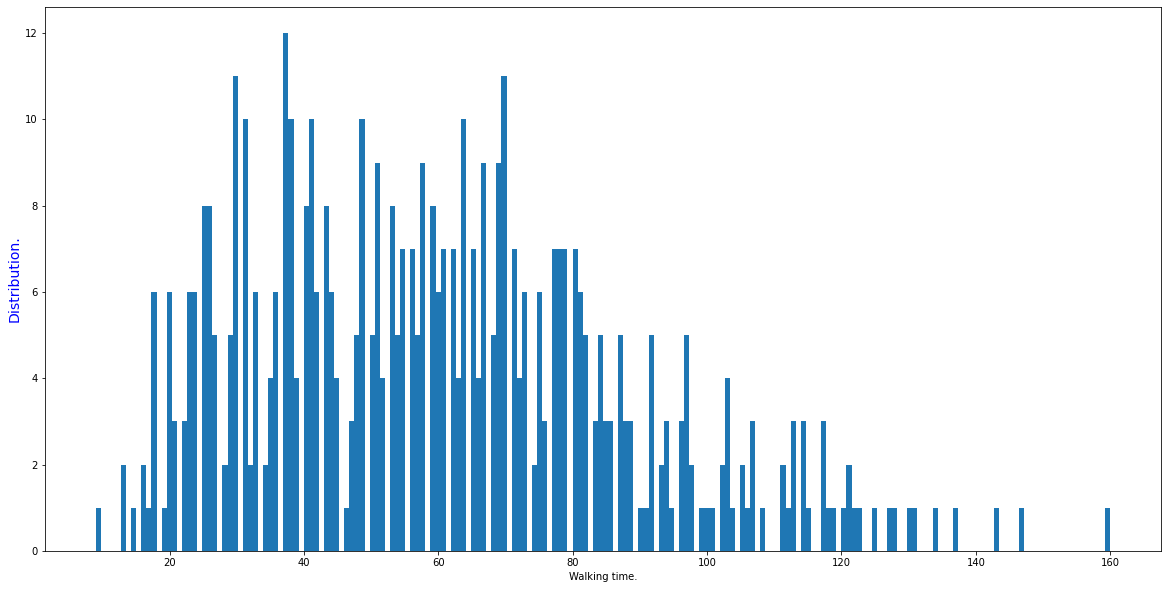

In [18]:
pyplot.rcParams["figure.figsize"] = [20, 10]
fig,ax = pyplot.subplots()
ax.set_xlabel("Walking time.")

ax.hist(walking_time_egress, bins=200)
ax.set_ylabel("Distribution.",fontsize=14, color = "blue")

### Quick estimation of free flow walk length.
We assume that the walk speeds are distributed between $3$ and $6$ km/h, then $E_w =  1.2$ m/s and $SD_w = .2$ m/s, then $\gamma_w ≈.17$ is sufficiently small and $\gamma_{w^{-1}} = 3 \%$.
Thus we estimate in meter and second:
$ E_{l} = 1.2 . E_{\tau}$,
$\gamma_l^2 = \gamma_{\tau}^2 - 3 \% $.

**Question:** Validation of $E_w = 1.2$ m/s ??

In [19]:
egress_time_mean = mean(walking_time_egress)
egress_time_std = std(walking_time_egress)
print(egress_time_mean)

60.245019920318725


In [20]:
egress_distance_mean = 1.2 * egress_time_mean
egress_distance_cv = sqrt((egress_time_std/egress_time_mean)**2 - 0.03)
egress_distance_std = egress_distance_mean*egress_distance_cv
print(egress_distance_mean)
print(egress_distance_std)

72.29402390438247
30.478533629734446


**Question:** Why not directly consider egress time distribution ?? see in the litterature

### MLE of free flow egress time with bivariate Gaussian vector for walking speed and distance.
Taking egress time of off-peak trips (ensuring free flow condition) and with one feasible run.

The egress time PDF reads $ \dot{T}(x) = \int w \dot{S}_w (w.x) dW(w)$, assuming $w \geq 0 $ and $w$ and $l$ statistically independant.

- What does it mean to look for correlated Gaussian distributions ?

- Check ex-post that speeds almost certain positive.

In [21]:
def egress_time_likelihood_gaussian(distance_mean, distance_sd, speed_mean, speed_sd, covariance, x):
    arg = [distance_mean, distance_sd, speed_mean, speed_sd, covariance, x]
    y_x = sqrt(distance_sd**2 + (x*speed_sd)**2 +  - 2*x*covariance)
    phi = norm.pdf((x*speed_mean - distance_mean)/y_x)
    num = speed_mean*(distance_sd**2 - x*covariance) + distance_mean*(x*speed_sd**2 - covariance)
    denom = y_x**3
    return num*phi/denom

In [22]:
def sum_log_likelihood(param, speed, covariance):
    log_likelihood = 0
    for egress_time in walking_time_egress:
        if egress_time >= 14:
            log_likelihood -= log(egress_time_likelihood_gaussian(param[0], param[1],speed, param[2], covariance, egress_time))
    print(log_likelihood)
    return log_likelihood


In [23]:
parameters_optimal = optimize.minimize(
    sum_log_likelihood,
    (60,1, 0.05),
    args=(1.2, 0),
    bounds=[(0, None), (0,None), (0,None)]
).x
print(parameters_optimal)

29991.500085346088
29991.50009317001
29991.49991533913
29991.491976094214
2528.127655199579
2528.127655154994
2528.1276552001395
2528.1276580062004
2528.0305570037945
2528.0305569592324
2528.0305570043524
2528.030559810054
2527.642287921847
2527.642287877387
2527.6422879223974
2527.6422907266774
2526.091249465387
2526.0912494213476
2526.091249465913
2526.0912522642393
2519.923628357959
2519.9236283156215
2519.9236283583464
2519.923631128742
2496.14088597161
2496.1408859373887
2496.1408859711883
2496.140888545426
2464.4802937340064
2464.48029377762
2464.4802937108834
2464.480290772333
2460.640181787431
2460.640181776382
2460.640181783076
2460.6401833170653
2587.9555964427673
2587.9555965883633
2587.955596348701
2587.9555799276354
2452.4497464212695
2452.4497464300357
2452.449746411643
2452.449746607775
2452.379336031327
2452.379336043479
2452.3793360206128
2452.3793359530364
2452.3650743921235
2452.3650744032757
2452.36507438174
2452.365074393238
2452.3639769733672
2452.363976984502
245

with $m_w = 1.2$:

with L-BFGS-B (default): 6.2s,  $m_l = 67,1$, $\sigma_l = 15,5$, $\sigma_w = 8,98. 10^{-6}$, $\chi = -6,73$


IndexError: index 3 is out of bounds for axis 0 with size 3

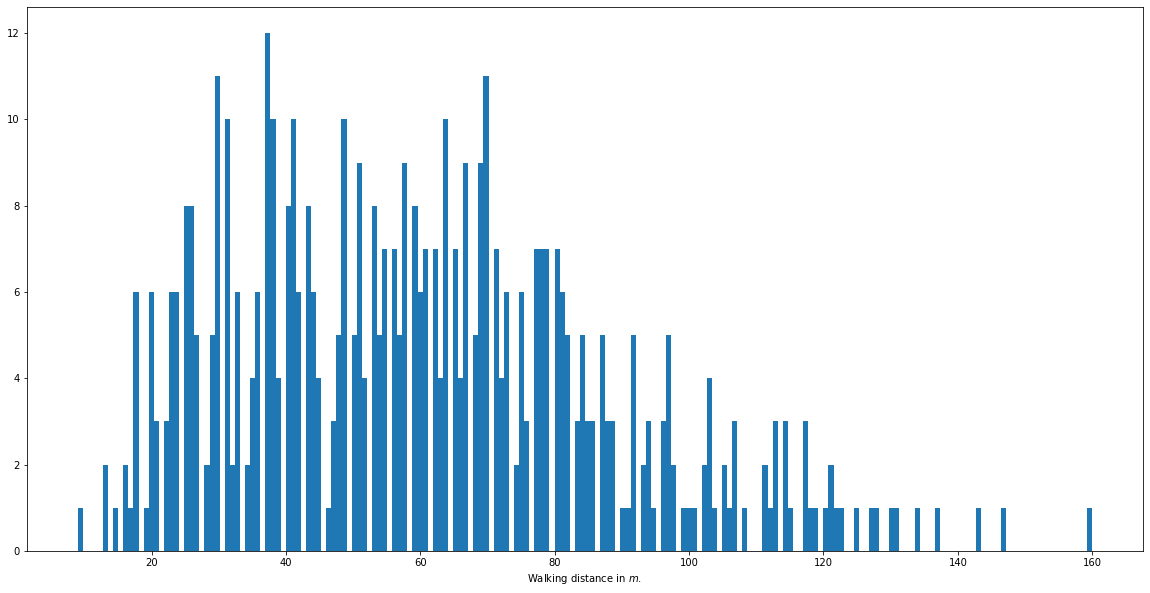

In [24]:
pyplot.rcParams["figure.figsize"] = [20, 10]
fig,ax = pyplot.subplots()
ax.set_xlabel("Walking distance in $m$.")

ax.hist(walking_time_egress, bins=200)
# ax.set_ylabel("Distribution.",fontsize=14, color = "blue")

walking_time_egress.sort()

estimated_distrib = [egress_time_likelihood_gaussian(parameters_optimal[0], parameters_optimal[1], 1.2, parameters_optimal[2], parameters_optimal[3],y) for y in walking_time_egress]

ax2=ax.twinx()
ax2.plot(walking_time_egress, estimated_distrib)

#### Asymptotic confidence interval.
Compute Hessian of total log-likelihood, evaluate at optimal parameters.

In [25]:
from numdifftools import Hessian

In [27]:
parameters = [59.6, 22.5, 1.01, 0.22]
def one_likelihood_term(param, covariance, x):
    return egress_time_likelihood_gaussian(param[0], param[1], param[2], param[3], covariance, x)

hess = Hessian(one_likelihood_term)

sum_hessian = [[0 for _ in range(len(parameters))] for _ in range(len(parameters))]
for x in walking_time_egress:
    sum_hessian += hess(parameters, 0, x)

print(sum_hessian)

[[-3.25842015e-03  1.97262403e-03  1.69073180e-01 -2.44244974e-03]
 [ 1.97262403e-03 -1.64877291e-03 -3.27190774e-02  1.17680545e-01]
 [ 1.69073180e-01 -3.27190774e-02 -1.30126996e+01  1.55046839e+00]
 [-2.44244974e-03  1.17680545e-01  1.55046839e+00 -5.47918831e+00]]


### Estimation of free flow egress distribution with log-normal distribution for walking distance and speed.
Taking egress time of off-peak trips (ensuring free flow condition) and with one feasible run.

The egress time PDF reads $ \dot{T}(x) = \frac{1}{\sigma_{\tau}x} \phi \left( \frac{\ln(x)- \mu_{\tau}}{\sigma_{\tau}} \right)$, assuming $w \geq 0 $ but no statistical independance.

$\mu_{\tau} = \frac{1}{A} \sum \tilde{\tau}_u$

$\sigma_{\tau}^2 = \frac{1}{A} \sum (\tilde{\tau}_u - \mu_{\tau})^2 $


In [ ]:
egress_time_log_mean = mean(log(walking_time_egress))
egress_time_log_std = sqrt(mean([(time - egress_time_log_mean)**2 for time in log(walking_time_egress)]))
print(egress_time_log_mean)
print(egress_time_log_std)

3.9847744956622257
0.49746983959469027


In [ ]:
walking_mean_log = log(1.2)
walking_std_log = log(0.35)
distance_mean_log =  egress_time_log_mean - walking_mean_log
diff_log = egress_distance_std**2 - walking_std_log**2

In [ ]:
def log_egress_time_distribution(x, mean, std):
    frac = 1/(std*x)
    phi = norm.pdf((log(x)-mean)/std)
    return frac*phi

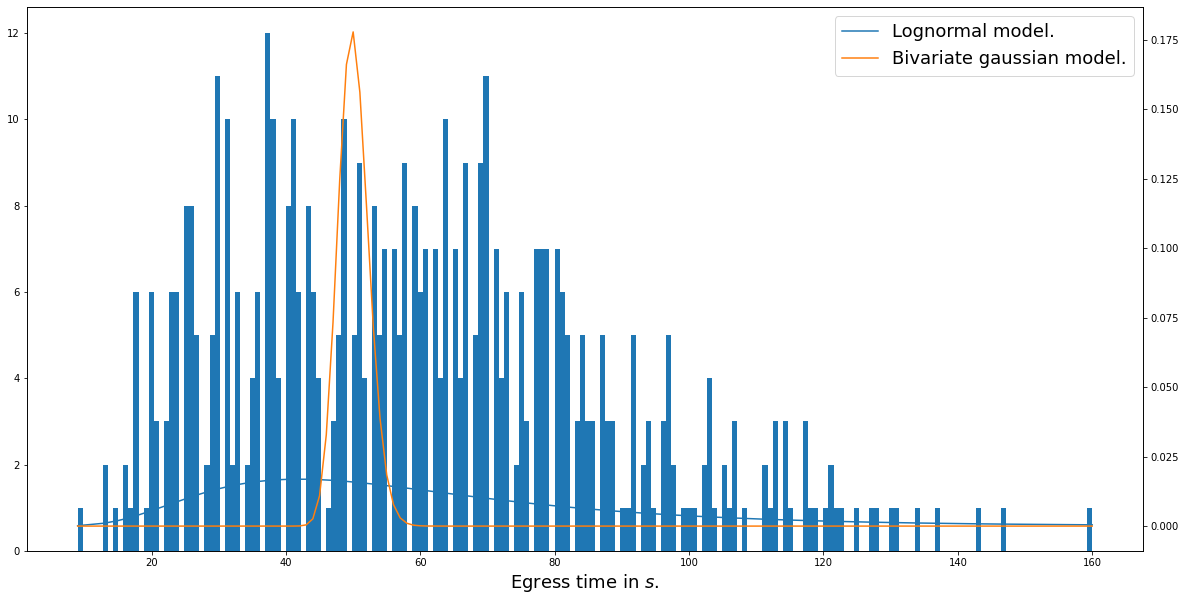

In [ ]:
pyplot.rcParams["figure.figsize"] = [20, 10]
pyplot.rc('legend', fontsize=18)  
pyplot.rc('axes', labelsize=18)   
fig,ax = pyplot.subplots()
ax.set_xlabel("Egress time in $s$.")

ax.hist(walking_time_egress, bins=200)

walking_time_egress.sort()
ax2=ax.twinx()
ax2.plot(walking_time_egress, [log_egress_time_distribution(time, egress_time_log_mean, egress_time_log_std) for time in walking_time_egress], label="Lognormal model.")

estimated_distrib_gaussian = [egress_time_likelihood_gaussian(parameters_optimal[0], parameters_optimal[1], 1.2, parameters_optimal[2], parameters_optimal[3],y) for y in walking_time_egress]
ax2.plot(walking_time_egress, estimated_distrib_gaussian, label="Bivariate gaussian model.")
ax2.legend(loc ="upper right")